# Opencv shape features extraction
Extracting feature is a useful way to determine classify images or images.
They can be used on there own, or within a machine learning model.

OpenCV can detect and extract contours and use those to determine features of this contour.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import cv2
from skimage.filters.rank import entropy
from skimage.morphology import disk
import numpy as np
from tomni.make_mask import make_mask_circle
from tomni import img_dim
from tomni.transformers import labels2contours

In [2]:

img = cv2.imread(r"D:\CytoData2021\Training\Good\Good_1_11d04h00m.tif", 0)

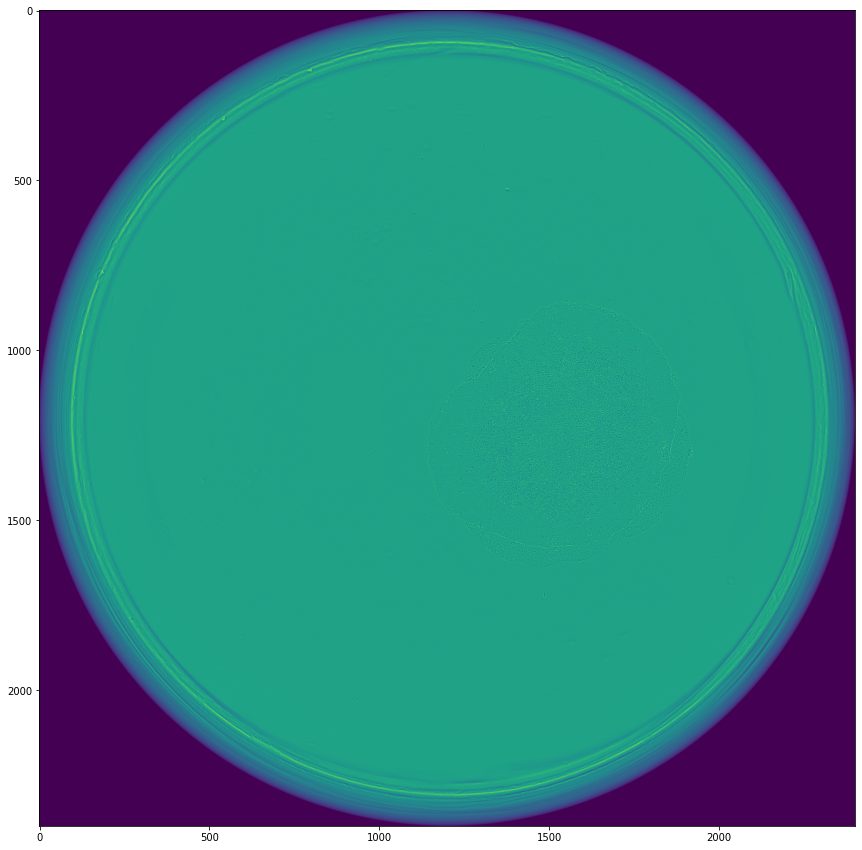

In [3]:

fig = plt.figure(figsize=(15,15))
imgplot = plt.imshow(img)

## Detecting the colony
Looking at the image we cannot threshold the colony easily.
To do this we will use entropy to separate background from foreground.
This is just an easy example, there are better (and more complex) methods out there.

We see the border of the well is also detected.
There are a lot smart ways to get rid of them; but I will not use them and just apply a mask of 85% the width of the image.

In [4]:
result_np = entropy(np.array(img).astype(np.uint8), disk(15))

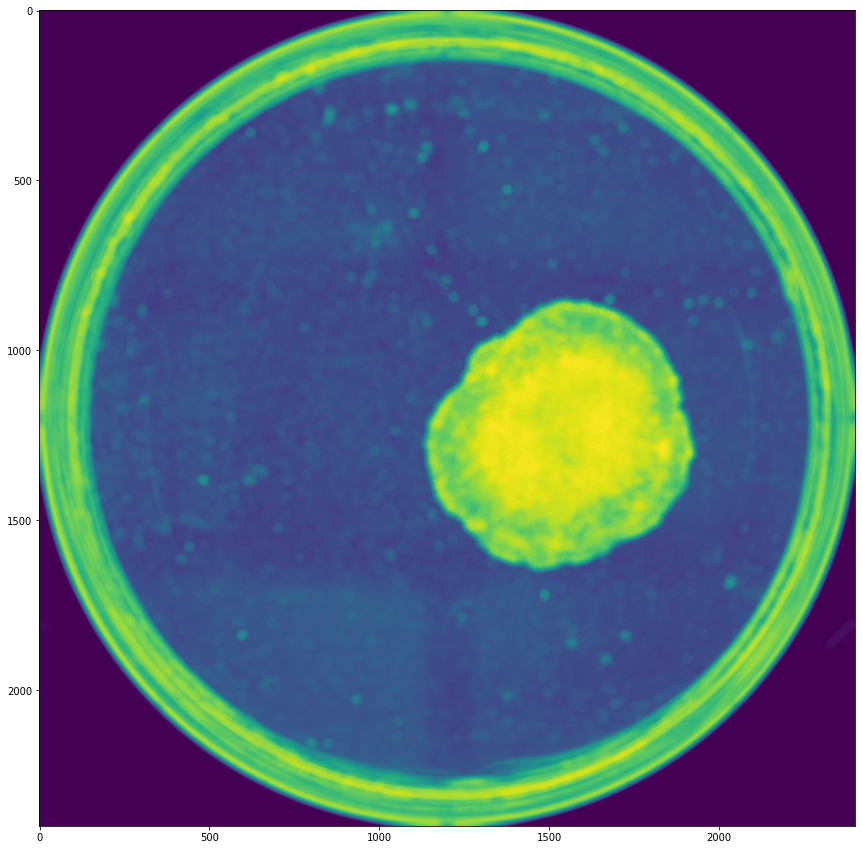

In [5]:

fig = plt.figure(figsize=(15,15))
imgplot = plt.imshow(result_np)

In [6]:
img_dim_result = img_dim(result_np)
mask = make_mask_circle(img_dim_result, int(min(img_dim_result) * 0.85))

masked_results = result_np * mask


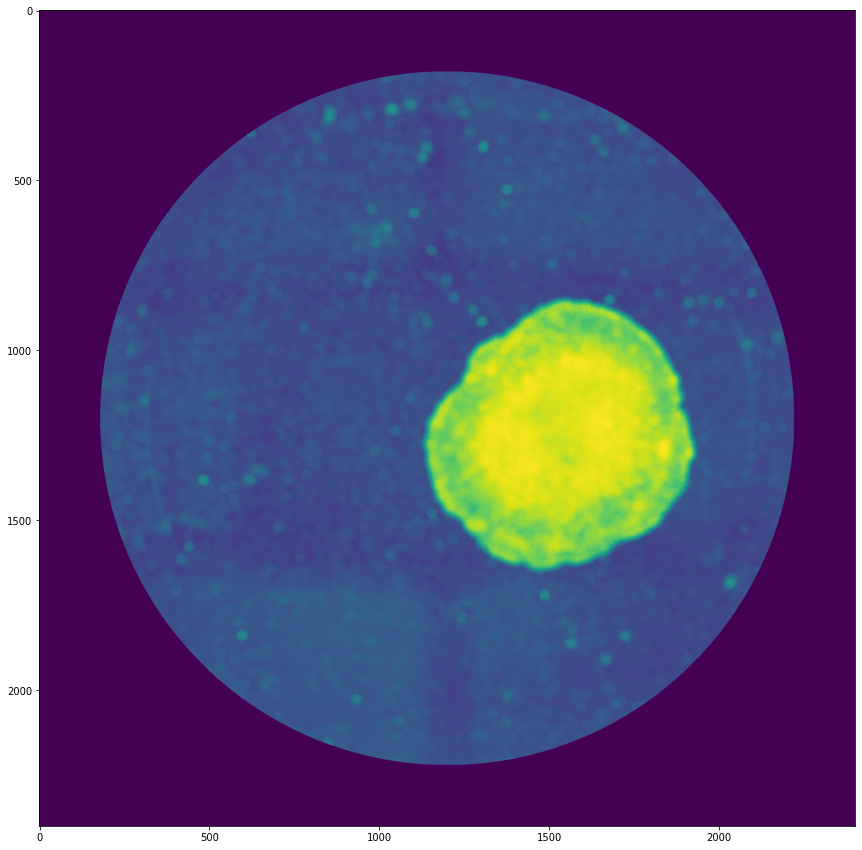

In [7]:
fig = plt.figure(figsize=(15,15))
imgplot = plt.imshow(masked_results)

## Thresholding

By thresholding correctly can be an PhD thesis on it own.
Here we use the old and tested technic of 'looks okay to me'.
I cannot provide a citation when this method was introduced.

In [8]:
thresholded_results = masked_results > 3.5

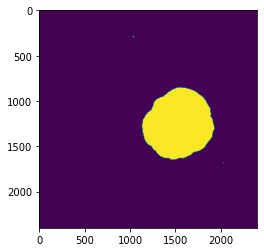

In [9]:
imgplot = plt.imshow(thresholded_results)

## Transforming from boolean array to contour

We will use connected components and labels2contours to go to the contours.
This way is way friendlier for you memory and time.
Findcontours is slow, numpy.where is memory inefficient the bigger the image.

This does not matter in this notebook but if we gone process all images you are gone notice.

We will only pick the biggest contour and cast it as a float32, opencv does not like float64 (double).

In [10]:
labels = cv2.connectedComponents(thresholded_results.astype(np.uint8))[1]
all_contours = labels2contours(labels)
print(len(all_contours))

3


In [11]:
biggest_contour = max(all_contours, key=lambda cnt: cv2.contourArea(cnt.astype(np.float32))).astype(np.float32)

## Extracting features

Lastly gone extract features from this contour.
Area and perimeter/arc length, are straight forward.

We also can enclose the contour with a circle or convex contour.
The difference between these enclosing shape and the original tells us something about the shape too.

Circularity is calculated by getting the difference in area between the enclosing circle and the area of the contour.

In [12]:
area = cv2.contourArea(biggest_contour)
arc_lenght = cv2.arcLength(biggest_contour, True)

convex_contour = cv2.convexHull(biggest_contour)
_,radius_enclosing_circle = cv2.minEnclosingCircle(biggest_contour)

area_convex = cv2.contourArea(convex_contour)
arc_length_convex = cv2.arcLength(convex_contour, True)

circularity = area / (radius_enclosing_circle ** 2 * math.pi)

print(radius_enclosing_circle,area, arc_lenght, area_convex, arc_length_convex, circularity)

405.4780578613281 463002.0 2637.2429749965668 470759.0 2454.6692173480988 0.8963926337456645


## Rounding up

We can now collect all of these steps in a script so we can run them on the whole batch.